In [40]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
import pandas as pd

import torch.nn.functional as F
import pytorch_lightning as pl
import sklearn.metrics as skm

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform
from symlie.model.networks.implicit import LinearImplicit
from symlie.model.setup import load_implicitP_statedict
from symlie.model.loss import mmd
from symlie.run import parse_options, main, process_args


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def plot_2columns(x_plots, x_titles):

    nrows = len(x_plots)
    batch_size = x_plots[0][0].shape[0]

    x_idx = np.random.randint(0, batch_size, 1)[0]
    fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
    for i, (x_l, x_r) in enumerate(x_plots):

        x_l, x_r = x_l.detach().cpu().numpy(), x_r.detach().cpu().numpy()

        for j, (x_lr, color) in enumerate(zip([x_l, x_r], ['tab:blue', 'tab:orange'])):
            xx = x_lr[x_idx]
            ax = axs[i, j]
            ax.plot(xx, 'o-', color = color)
            ax.plot([len(xx)-1, len(xx)], [xx[-1], xx[0]], '--', color=color)
            ax.plot([-1, 0], [xx[-1], xx[0]], '--', color=color)
            ax.set_xticks([])
            ax.set_yticks([0])
            ax.set_title(x_titles[i][j])
    plt.show()

def plot1d(x, logy = True, title = None):
    plt.figure(figsize=(5,2))
    plt.plot(x)
    if logy: plt.yscale('log')
    plt.title(title)
    plt.show()

In [42]:
args = parse_options(notebook=True)

args.noise_std = 0.1
args.grid_size = (7, 7)
args.eps_mult = [0.0, 1.0, 1.0, 1.0]
# args.eps_mult = [0.0, 0.0, 0.0, 0.0]
args.net = 'TrainP'
args.data_dir = '../data/MNIST'

args.do_return = True
args.logger = None

args.n_train = 100

process_args(args)

# Training
_, _, datamodule = main(args)

n_epochs = 1000
# n_epochs = 10
size =  7
features = size**2


Seed set to 42


Running without logging


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [43]:
trainloader = datamodule.train_dataloader()
testloader = datamodule.test_dataloader()

In [44]:
transform_funcs = {k: v() for k, v in CalculatedP(size = features).transform_funcs.items()}

In [45]:
class PredictionLearner(nn.Module):
    def __init__(self, size, method):
        super().__init__()
        self.size = size
        self.method = method

        self.weight1 = nn.Parameter(torch.rand(size, size))

        match method:
            case 'mlp':
                self.f_eval = self.mlp
                self.lossweights = [1, 1]
            case 'none':
                self.f_eval = self.vanilla
                self.lossweights = [0,1]
            case 'space_translation':
                self.f_eval = self.space_translation
                self.lossweights = [0,1]

        features = size**2
        self.layer1 = nn.Linear(size, size, bias = True)
        self.layers = nn.Sequential(
            nn.Linear(features,size),
            nn.ReLU(),
            nn.Linear(size,features),
            # nn.ReLU(),
            # nn.Linear(features,features),
            # nn.ReLU(),
            # nn.Linear(features,features),
        )
        
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(size, 10, bias = False)

    def mlp(self, weight):
        weight = weight.view(self.size**2)
        weight = self.layers(weight)
        weight = weight.view(self.size, self.size)
        return weight
    
    def vanilla(self, weight):
        return weight
        w = weight
        w = w.view(size**2)
        w = transform_funcs['none'] @ w
        w = w.view(size, size)
        return w
    
    def space_translation(self, weight):
        w = weight
        w = w.view(size**2)
        w = transform_funcs['space_translation'] @ w
        w = w.view(size, size)
        return w

    
    def forward(self, x):
        
        # weight = self.f_eval(self.weight1)
        # x = x @ self.weight1.T

        x = self.layer1(x)
        
        x = self.activation(x)
        x = self.layer2(x)
        return x

In [46]:
# x, y, _ = next(iter(trainloader))

# i = 5
# print(x.shape)
# x0 = x[i].view(args.grid_size).unsqueeze(0)
# print(x0.shape)

# plt.figure(figsize=(3,3))
# plt.imshow(x0.squeeze(0))
# plt.show()

# shiftx = -3
# shifty = 1
# rot    = 2

# x1 = torch.roll(x0, shifts = shiftx, dims = 2)
# x1 = torch.roll(x1, shifts = shifty, dims = 1)
# x1 = torch.rot90(x1, k = rot, dims = (1,2))

# plt.figure(figsize=(3,3))
# plt.imshow(x1.squeeze(0))
# plt.title(y[i].item())
# plt.show()

In [47]:
seeds = [41, 42, 43]
methods = ['none', 'mlp']

seeds = [41, 42]
methods = ['none']

rs = []

for seed in seeds:
  torch.manual_seed(seed)
  for method in methods:

    # Initialize the MLP
    mlp = PredictionLearner(size=features, method=method)

    # Define the loss function and optimizer
    criterion1     = nn.MSELoss()
    criterion2     = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

    losses1 = []
    losses2 = []

    # Run the training loop
    for epoch in tqdm(range(0, n_epochs), desc = f'seed={seed}, method={method}'):
        
        current_loss1 = 0.0
        current_loss2 = 0.0
        
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
          
            # Get inputs
            x, y, _ = data
            batch_size = x.size(0)
            
            # Zero the gradients
            optimizer.zero_grad()

            x_a = x.clone()
            x_b = x.clone()
            shiftx = (torch.rand((1))*size).int().item()
            shifty = (torch.rand((1))*size).int().item()
            rot = (torch.rand((1))*4).int().item()

            weight = mlp.weight1
            o_a = x_a @ mlp.f_eval(weight).T

            o_a_prime = o_a.reshape(batch_size, size, size)
            o_a_prime = torch.roll(o_a_prime, shiftx, 2)
            o_a_prime = torch.roll(o_a_prime, shifty, 1)
            o_a_prime = torch.rot90(o_a_prime, k = rot, dims = (1,2))
            o_a_prime = o_a_prime.reshape(batch_size, features)


            x_b_prime = x_b.reshape(batch_size, size, size)
            x_b_prime = torch.roll(x_b_prime, shiftx, 2)
            x_b_prime = torch.roll(x_b_prime, shifty, 1)
            x_b_prime = torch.rot90(x_b_prime, k = rot, dims = (1,2))
            x_b_prime = x_b_prime.reshape(batch_size, features)
            
            o_b_prime = x_b_prime @ mlp.f_eval(weight).T

            # Compute loss
            loss1 = criterion1(o_a_prime, o_b_prime)


            y_pred = mlp(x)


            # Compute loss
            # print(y_pred.shape, y.squeeze(1).shape)
            loss2 = criterion2(y_pred, y.squeeze(1).long())

            loss = mlp.lossweights[0]*loss1 + mlp.lossweights[1]*loss2

            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss1 += loss1.item()
            current_loss2 += loss2.item()
        current_loss1 = current_loss1 / len(trainloader)
        current_loss2 = current_loss2 / len(trainloader)
        losses1.append(current_loss1)
        losses2.append(current_loss2)

    mlp = mlp.eval()
    test_loss = 0.0
    y_trues, y_preds, y_preds_raw = [], [], []
    for i, data in enumerate(testloader, 0):
      x, y, _ = data
      y_pred = mlp(x)

      # loss = criterion2(y_pred, y)
      loss = criterion2(y_pred, y.squeeze(1).long())

      test_loss += loss.item() / len(testloader)
      y_trues.append(y.detach().squeeze(1))
      y_preds_raw.append(y_pred.detach())
      y_pred = torch.argmax(y_pred, dim = 1)
      y_preds.append(y_pred.detach())

    r = {
        'seed': seed,
        'method': method,
        'test_loss': test_loss,
        'losses1': losses1,
        'losses2': losses2,
        'y_trues': torch.cat(y_trues),
        'y_preds': torch.cat(y_preds),
        'y_preds_raw': torch.cat(y_preds),
    }
    rs.append(r)

    # plot1d(losses, logy = True, title = f'seed={seed}, loss={test_loss:.6f}')

seed=42, method=none: 100%|██████████| 1000/1000 [00:04<00:00, 200.58it/s]


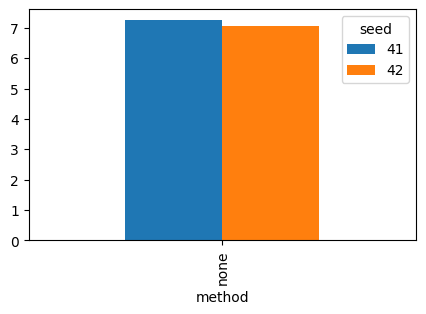

In [48]:
results = pd.DataFrame(rs)
results = results.set_index(['method']).sort_index()

results_testloss = results.pivot(columns = 'seed', values = 'test_loss')
results_losses = results.pivot(columns = 'seed', values = ['losses1', 'losses2'])
results_ys = results.pivot(columns = 'seed', values = ['y_trues', 'y_preds'])

fig, ax = plt.subplots(figsize=(5, 3))
results_testloss.plot(kind = 'bar', figsize = (5, 3), logy=False, ax = ax)
plt.show()

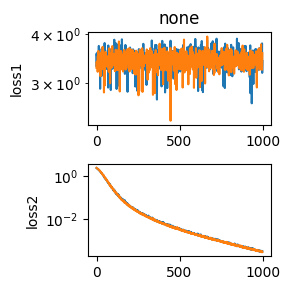

In [50]:
n_plots = len(methods)
fig, axs = plt.subplots(2, n_plots, figsize = (3*n_plots, 3), tight_layout = True)
if n_plots == 1: axs = axs[:, None]

for i, method in enumerate(methods):
    for j, seed in enumerate(seeds):
        r = results[(results.index == method) & (results['seed'] == seed)]
        assert len(r) == 1
        r = r.iloc[0]

        axs[0, i].plot(r['losses1'], label = f'seed={seed}')
        axs[1, i].plot(r['losses2'], label = f'seed={seed}')

    axs[0, i].set_yscale('log')
    axs[1, i].set_yscale('log')

    axs[0, i].set_title(f'{method}')
    axs[0, 0].set_ylabel('loss1')
    axs[1, 0].set_ylabel('loss2')

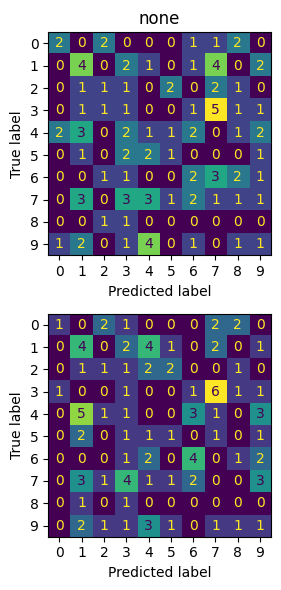

In [53]:
n_plots = len(methods)
fig, axs = plt.subplots(len(seeds), n_plots, figsize = (3*n_plots, 3*len(seeds)), tight_layout = True)
if n_plots == 1: axs = axs[None, :]

for i, method in enumerate(methods):
    for j, seed in enumerate(seeds):
        r = results[(results.index == method) & (results['seed'] == seed)]
        assert len(r) == 1
        r = r.iloc[0]

        y_trues = r['y_trues'].to(dtype = torch.int).numpy()
        y_preds = r['y_preds'].to(dtype = torch.int).numpy()

        ax = axs[i, j]
        # ax = axs[j, i]
        skm.ConfusionMatrixDisplay.from_predictions(y_trues, y_preds, ax = ax, colorbar=False)
    axs[0, i].set_title(f'{method}')
    
